In [10]:
using Interpolations
using DelimitedFiles
using Cubature
using Plots
using LaTeXStrings

In [11]:
kpk = readdlm("test_pk.txt", comments=true)
pk_itp = interpolate((kpk[:,1],), kpk[:,2], Gridded(Linear()));

In [12]:
b = 2
f = 0.7
pk2d = (μ, k) -> (b + μ^2*f)^2*pk_itp(k)

#9 (generic function with 1 method)

In [13]:
kp = (k, μ, αV, ϵ) -> k*sqrt(αV^2*ϵ^2*μ^2 + αV^2/ϵ*(1 - μ^2))
μp = (k, μ, αV, ϵ) -> μ*αV*ϵ/sqrt(αV^2*ϵ^2*μ^2 + αV^2/ϵ*(1 - μ^2))

#13 (generic function with 1 method)

In [14]:
L0 = x -> 1
L2 = x -> (3*x^2 - 1)/2
L4 = x -> (35*x^4 - 30*x^2 + 3)/8

#19 (generic function with 1 method)

In [15]:
function pkprime(kgrid, weight, αV, ϵ)
    Nk = size(kgrid)[1]
    pp = zeros(Nk)
    for i in 1:Nk
        pp[i] = hquadrature(x -> pk2d(μp(kgrid[i], x, αV, ϵ), kp(kgrid[i], x, αV, ϵ))*weight(x), -1, 1, reltol=1e-4)[1]
    end
    return pp
end

pkprime (generic function with 1 method)

In [16]:
function pell(kgrid, αV, ϵ)
    p0 = pkprime(kgrid, L0, αV, ϵ)*1/2
    p2 = pkprime(kgrid, L2, αV, ϵ)*5/2
    p4 = pkprime(kgrid, L4, αV, ϵ)*9/2
    return p0, p2, p4
end
kgrid = collect(range(0.00, 0.20, step=0.01))
αV = 1.00
ϵ = 1.00
p0ref, p2ref, p4ref = pell(kgrid, αV, ϵ)
p0refp, p2refp, p4refp = pell(kgrid .+ 0.001, αV, ϵ)
dp0 = (p0refp .- p0ref)/0.001.*kgrid
dp2 = (p2refp .- p2ref)/0.001.*kgrid
dp4 = (p4refp .- p4ref)/0.001.*kgrid;

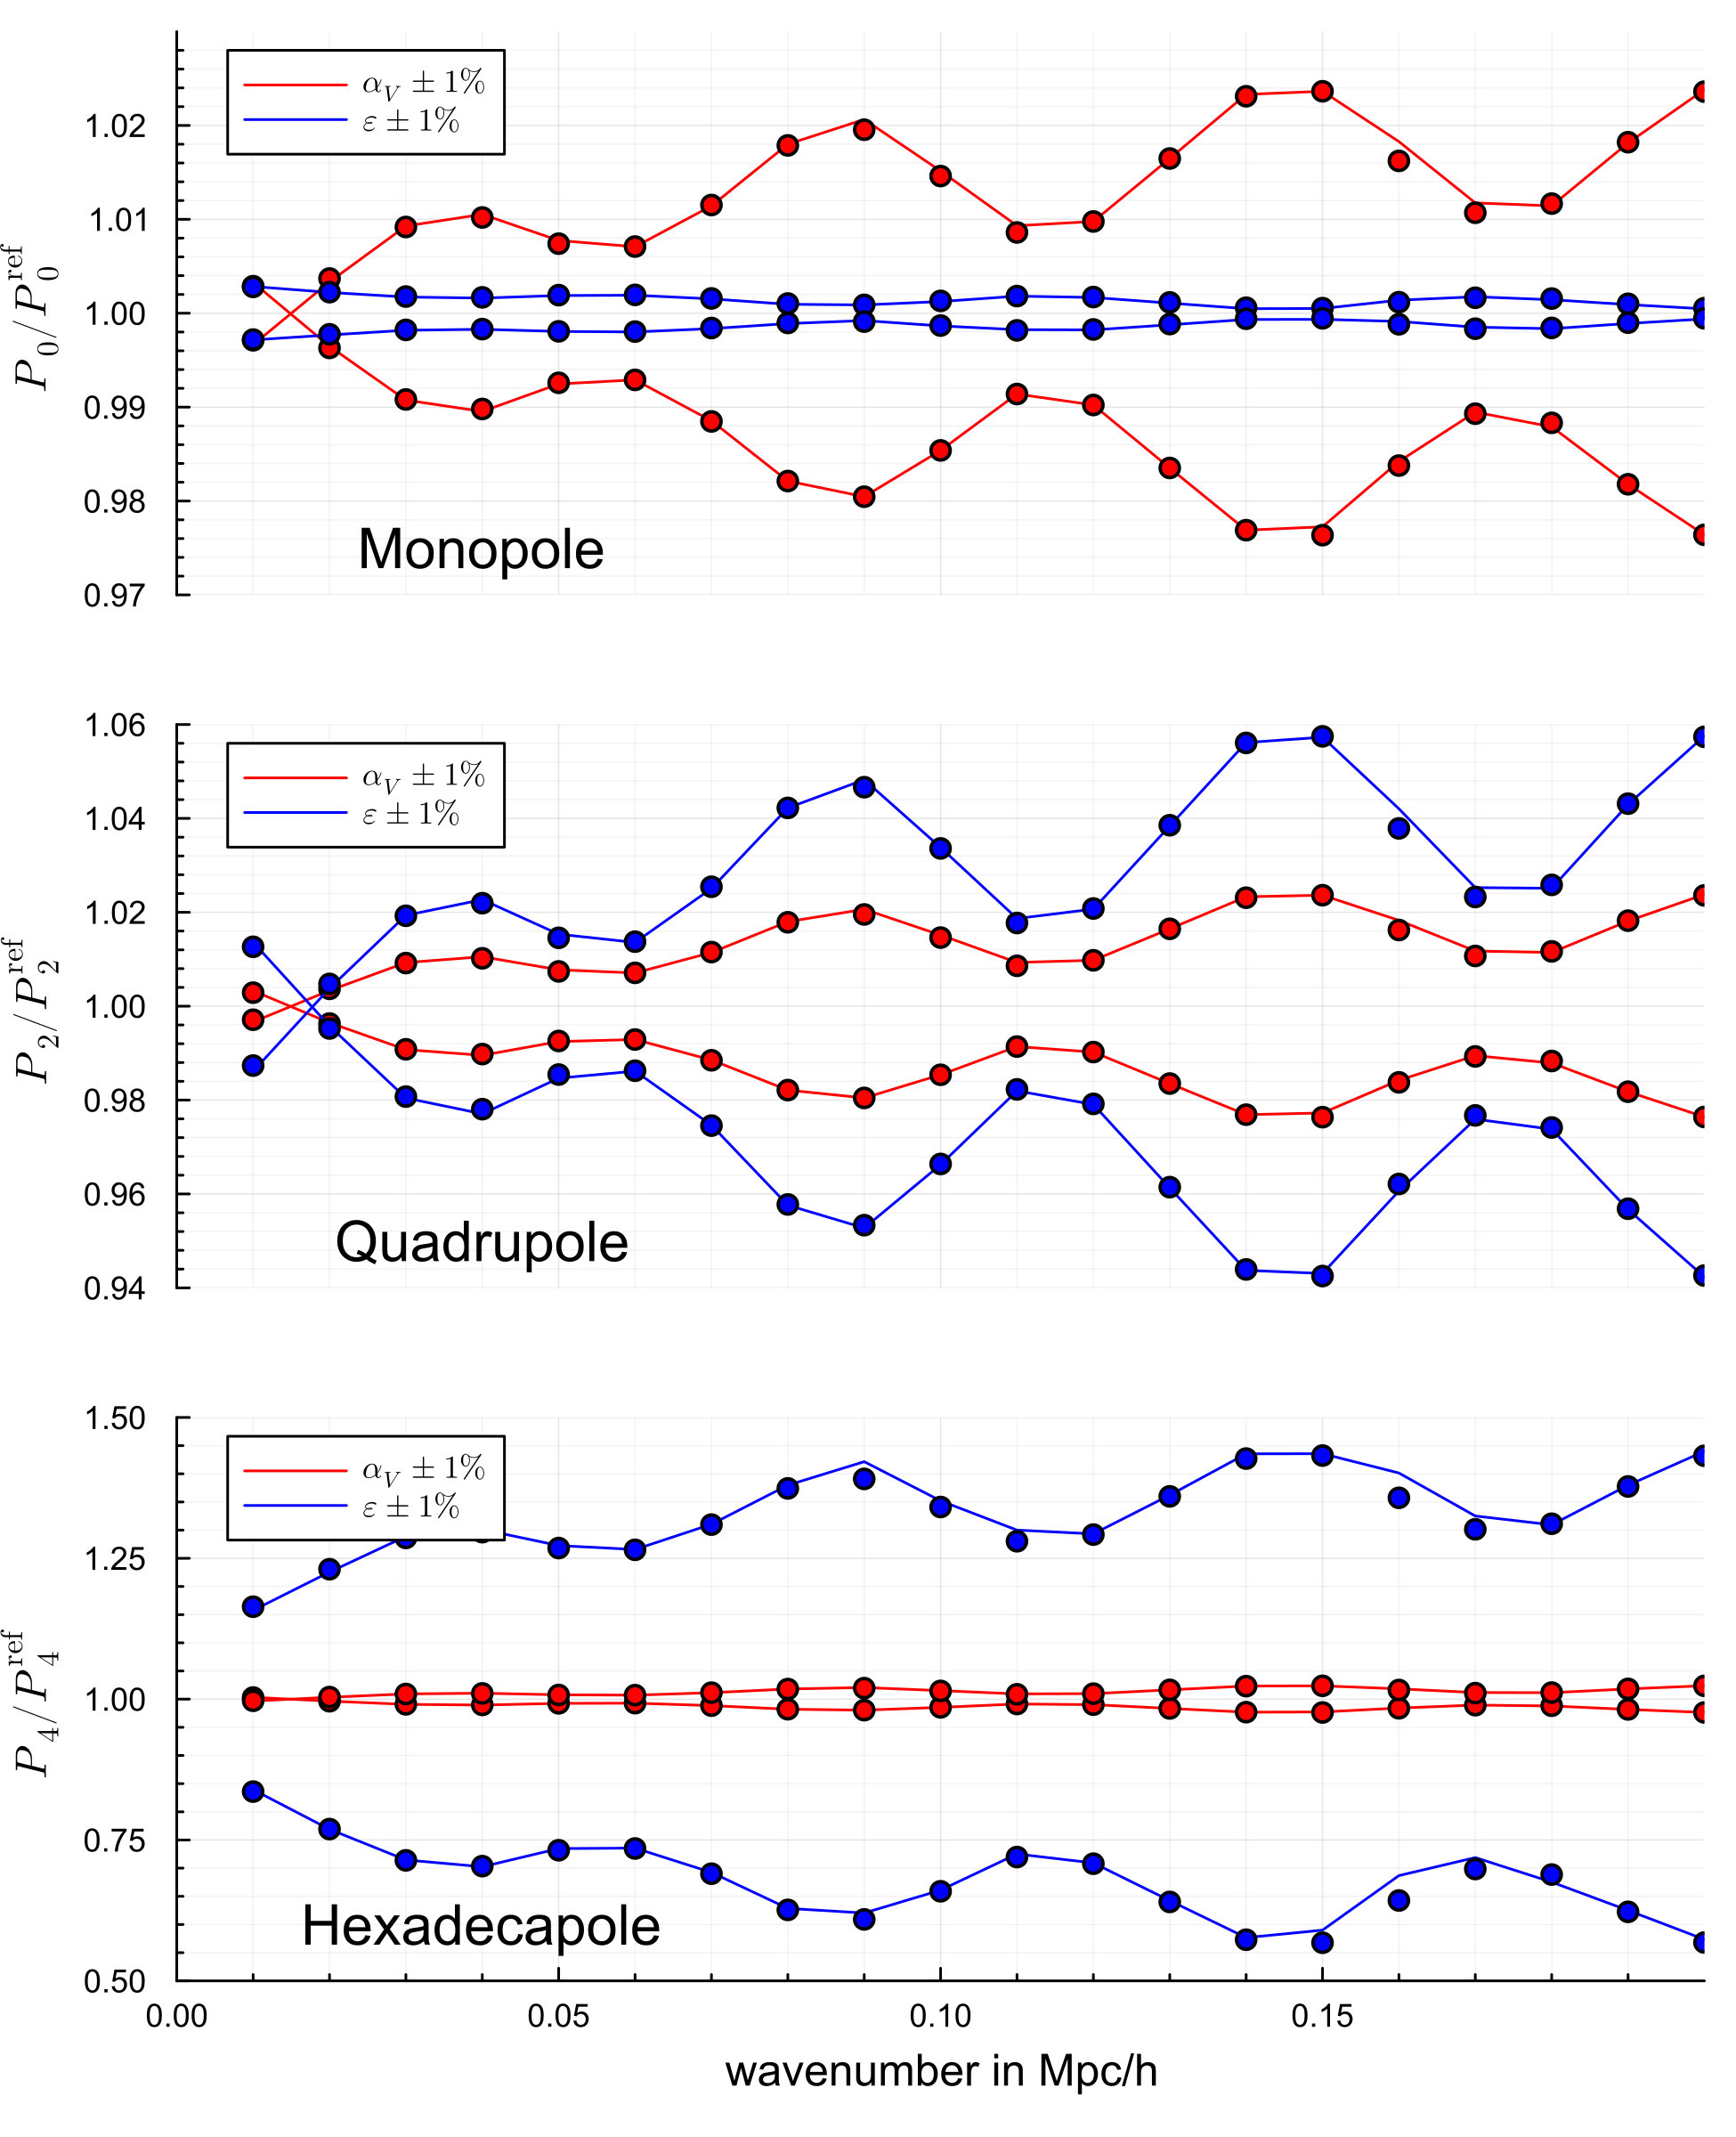

In [17]:
function pellth(p0ref, p2ref, p4ref, dp0, dp2, dp4, α, ϵ)
    δα = αV - 1
    δϵ = ϵ - 1
    p0th = p0ref + dp0*δα + (1/5)*dp2*δϵ + (3/5)*p2ref*δϵ
    p2th = p2ref + dp2*δα + (1)*dp0*δϵ + (2/7)*dp2*δϵ + (2/7)*dp4*δϵ + (3/7)*p2ref*δϵ + (10/7)*p4ref*δϵ
    p4th = p4ref + dp4*δα + (18/35)*dp2*δϵ + (20/77)*dp4*δϵ + (-36/35)*p2ref*δϵ + (30/77)*p4ref*δϵ
    return p0th, p2th, p4th
end
αV = 1.01
ϵ = 1.00
p0, p2, p4 = pell(kgrid, αV, ϵ)
p0th, p2th, p4th = pellth(p0ref, p2ref, p4ref, dp0, dp2, dp4, αV, ϵ)
plot(kgrid, p0./p0ref, color=:red, label=L"\alpha_V \pm 1\%", layout=(3,1), size=(650, 800), dpi=300)
scatter!(kgrid, p0th./p0ref, color=:red, label=:none, subplot=1, xaxis=:false)
plot!(kgrid, p2./p2ref, color=:red, label=L"\alpha_V \pm 1\%", subplot=2)
scatter!(kgrid, p2th./p2ref, color=:red, label=:none, subplot=2, xaxis=:false)
plot!(kgrid, p4./p4ref, color=:red, label=L"\alpha_V \pm 1\%", subplot=3)
scatter!(kgrid, p4th./p4ref, color=:red, label=:none, subplot=3)
αV = 0.99
ϵ = 1.00
p0, p2, p4 = pell(kgrid, αV, ϵ)
p0th, p2th, p4th = pellth(p0ref, p2ref, p4ref, dp0, dp2, dp4, αV, ϵ)
plot!(kgrid, p0./p0ref, color=:red, label=:none, subplot=1)
scatter!(kgrid, p0th./p0ref, color=:red, label=:none, subplot=1)
plot!(kgrid, p2./p2ref, color=:red, label=:none,subplot=2)
scatter!(kgrid, p2th./p2ref, color=:red, label=:none,subplot=2)
plot!(kgrid, p4./p4ref, color=:red, label=:none,subplot=3)
scatter!(kgrid, p4th./p4ref, color=:red, label=:none,subplot=3)
αV = 1.00
ϵ = 1.01
p0, p2, p4 = pell(kgrid, αV, ϵ)
p0th, p2th, p4th = pellth(p0ref, p2ref, p4ref, dp0, dp2, dp4, αV, ϵ)
plot!(kgrid, p0./p0ref, color=:blue, label=L"\epsilon \pm 1\%", subplot=1)
scatter!(kgrid, p0th./p0ref, color=:blue, label=:none, subplot=1)
plot!(kgrid, p2./p2ref, color=:blue, label=L"\epsilon \pm 1\%", subplot=2)
scatter!(kgrid, p2th./p2ref, color=:blue, label=:none, subplot=2)
plot!(kgrid, p4./p4ref, color=:blue, label=L"\epsilon \pm 1\%", subplot=3)
scatter!(kgrid, p4th./p4ref, color=:blue, label=:none, subplot=3)
αV = 1.00
ϵ = 0.99
p0, p2, p4 = pell(kgrid, αV, ϵ)
p0th, p2th, p4th = pellth(p0ref, p2ref, p4ref, dp0, dp2, dp4, αV, ϵ)
plot!(kgrid, p0./p0ref, color=:blue, label=:none, legend=:topleft, subplot=1)
scatter!(kgrid, p0th./p0ref, color=:blue, label=:none, subplot=1)
plot!(kgrid, p2./p2ref, color=:blue, label=:none, legend=:topleft, subplot=2)
scatter!(kgrid, p2th./p2ref, color=:blue, label=:none, subplot=2)
plot!(kgrid, p4./p4ref, color=:blue, label=:none, legend=:topleft, subplot=3)
scatter!(kgrid, p4th./p4ref, color=:blue, label=:none, subplot=3)
plot!(xlabel="wavenumber in Mpc/h", ylabel=L"P_4/P^\mathrm{ref}_4", subplot=3)
plot!(ylabel=L"P_2/P^\mathrm{ref}_2", subplot=2)
plot!(ylabel=L"P_0/P^\mathrm{ref}_0", subplot=1)
plot!(xrange=(0,0.20), yrange=(0.97,1.03),grid=true,fontfamily="Arial",minorticks=:true,minorgrid=true, subplot=1)
plot!(xrange=(0,0.20), yrange=(0.94,1.06), yticks=([0.94, 0.96, 0.98, 1.00, 1.02, 1.04, 1.06]), grid=true,fontfamily="Arial",minorticks=:true,minorgrid=true, subplot=2)
plot!(xrange=(0,0.20), yrange=(0.5,1.5),grid=true,fontfamily="Arial",minorticks=:true,minorgrid=true, subplot=3)
annotate!(0.04, 0.975, "Monopole", fontfamily="Arial", subplot=1)
annotate!(0.04, 0.95, "Quadrupole", fontfamily="Arial", subplot=2)
annotate!(0.04, 0.60, "Hexadecapole", fontfamily="Arial", subplot=3)
#savefig("Pap.png")


In [18]:
function solve_triangular_geometry(μ1, ϕ, k1, k2, k3)
    μ12 = (k1^2 + k2^2 - k3^2)/(2*k1*k2)
    μ31 = (k3^2 + k1^2 - k2^2)/(2*k3*k1)
    μ23 = (k2^2 + k3^2 - k1^2)/(2*k2*k3)
    #println(μ12, " ", μ1)
    μ3 = - μ1*μ12 - sqrt(1 - μ1^2)*sqrt(1 - μ12^2)*cos(ϕ)
    μ2 = -(μ1*k1 + μ3*k3)/k2
    return μ2, μ3, μ12, μ23, μ31
end

function tree_level_bk(μ1, ϕ, k1, k2, k3, b1, b2, f, pk)

    pk1 = pk(k1)
    pk2 = pk(k2)
    pk3 = pk(k3)

    μ2, μ3, μ12, μ23, μ31 = solve_triangular_geometry(μ1, ϕ, k1, k2, k3)
 
    Z1k1 = b1 + f*μ1^2
    Z1k2 = b1 + f*μ2^2
    Z1k3 = b1 + f*μ3^2
 
    F12 = 5/7 + μ12/2*(k1/k2 + k2/k1) + 2/7*μ12^2
    F23 = 5/7 + μ23/2*(k2/k3 + k3/k2) + 2/7*μ23^2
    F31 = 5/7 + μ31/2*(k3/k1 + k1/k3) + 2/7*μ31^2
 
    G12 = 3/7 + μ12/2*(k1/k2 + k2/k1) + 4/7*μ12^2
    G23 = 3/7 + μ23/2*(k2/k3 + k3/k2) + 4/7*μ23^2
    G31 = 3/7 + μ31/2*(k3/k1 + k1/k3) + 4/7*μ31^2
 
    Z2k12 = b2/2. + b1*F12 + f*μ3^2*G12
    Z2k12 -= f*μ3*k3/2*(μ1/k1*Z1k2 + μ2/k2*Z1k1)
    Z2k23 = b2/2. + b1*F23 + f*μ1^2*G23
    Z2k23 -= f*μ1*k1/2*(μ2/k2*Z1k3 + μ3/k3*Z1k2)
    Z2k31 = b2/2. + b1*F31 + f*μ2^2*G31
    Z2k31 -= f*μ2*k2/2*(μ3/k3*Z1k1 + μ1/k1*Z1k3)

    Bi = Z2k12*Z1k1*Z1k2*pk1*pk2
    Bi += Z2k23*Z1k2*Z1k3*pk2*pk3
    Bi += Z2k31*Z1k3*Z1k1*pk3*pk1
 
    return 2*Bi 
end

function bk5d(μ, ϕ, k1, k2, k3)
    return tree_level_bk(μ, ϕ, k1, k2, k3, 2, 0.6, 0.7, pk_itp)
end

bk5d (generic function with 1 method)

In [19]:
function k1t(k1, k2, k3, μ, ϕ, αV, ϵ)
    Apar = αV*ϵ
    Aperp = αV/sqrt(ϵ)
    return k1 * sqrt(Apar^2 * μ^2 + Aperp^2 * (1 - μ^2))
end
function k2t(k1, k2, k3, μ, ϕ, αV, ϵ)
    d = (k1^2 + k3^2 - k2^2)/(2*k1)
    r = sqrt(k3^2 - d^2)
    eps1 = atan((r*cos(ϕ))/d)
    Apar = αV*ϵ
    Aperp = αV/sqrt(ϵ)
    theta = acos(μ)
    return sqrt(k2^2 + (Apar-1)^2 * (k1 - k3*sqrt(1 - (r^2 * (sin(ϕ))^2)/k3^2)*(cos(eps1 + theta))^2)^2 + (Aperp-1)^2 * (k1 - k3*sqrt(1 - (r^2 * (sin(phi))^2)/k3^2)*(sin(eps1 + theta))^2)^2 + (r^2 * ((Aperp - 1)^2 *sin(phi))^2)/k3^2)
end
function k3t(k1, k2, k3, μ, ϕ, αV, ϵ)
    d = (k1^2 + k3^2 - k2^2)/(2*k1)
    r = sqrt(k3^2 - d^2)
    eps1 = atan((r*cos(ϕ))/d)
    Apar = αV*ϵ
    Aperp = αV/sqrt(ϵ)
    theta = acos(μ)
    return  k3 * sqrt((1 - (r^2 * (sin(phi))^2)/k3^2)*(((cos(eps1 + theta))^2)*Apar + ((sin(eps1 + theta))^2)*Aperp ) + (r^2 * (sin(phi))^2 * Aperp )/k3^2)
end
function μt(k1, k2, k3, μ, ϕ, αV, ϵ)
    return μ*αV*ϵ/sqrt(αV^2*ϵ^2*μ^2 + αV^2/ϵ*(1 - μ^2))
end
function ϕt(k1, k2, k3, μ, ϕ, αV, ϵ) 
    d = (k1^2 + k3^2 - k2^2)/(2*k1)
    Aperp = αV/sqrt(ϵ)
    r = sqrt(k3^2 - d^2)
    dt = (k1t^2 + k3t^2 - k2t^2)/(2*k1t)
    rt = sqrt(k3t^2 - dt^2)
    return asin((r/rt)*sin(ϕ)*Aperp) 
end

ϕt (generic function with 1 method)

In [80]:
function Y00(x)
    return 1/2/sqrt(π)
end
function Y20(x)
    return sqrt(5)/4/sqrt(π)*(3*cos.(x).^2 .-1)
end
function Y40(x)
    return 3/16/sqrt(π)*(35*cos.(x).^4 .-30*cos.(x).^2 .+3)
end
function b00equi(k1, k2, k3, αV, ϵ)
    Nk = size(kgrid)[1]
    pp = zeros(Nk)
    for i in 2:Nk
        pp[i] = hcubature(x -> bk5d(μp(kgrid[i], cos(x[1]), αV, ϵ), x[2], kp(k1[i], cos(x[1]), αV, ϵ), kp(k2[i], cos(x[1]), αV, ϵ), kp(k3[i], cos(x[1]), αV, ϵ))*Y00(x[1])*sin(x[1]), [0, 0], [π, 2*π], reltol=1e-4)[1]
    end
    return pp
end
function b20equi(k1, k2, k3, αV, ϵ)
    Nk = size(kgrid)[1]
    pp = zeros(Nk)
    for i in 2:Nk
        pp[i] = hcubature(x -> bk5d(μp(kgrid[i], cos(x[1]), αV, ϵ), x[2], kp(k1[i], cos(x[1]), αV, ϵ), kp(k2[i], cos(x[1]), αV, ϵ), kp(k3[i], cos(x[1]), αV, ϵ))*Y20(x[1])*sin(x[1]), [0, 0], [π, 2*π], reltol=1e-4)[1]
    end
    return pp
end
function b40equi(k1, k2, k3, αV, ϵ)
    Nk = size(kgrid)[1]
    pp = zeros(Nk)
    for i in 2:Nk
        pp[i] = hcubature(x -> bk5d(μp(kgrid[i], cos(x[1]), αV, ϵ), x[2], kp(k1[i], cos(x[1]), αV, ϵ), kp(k2[i], cos(x[1]), αV, ϵ), kp(k3[i], cos(x[1]), αV, ϵ))*Y40(x[1])*sin(x[1]), [0, 0], [π, 2*π], reltol=1e-4)[1]
    end
    return pp
end

b40equi (generic function with 1 method)

In [89]:
B00fid = b00equi(kgrid, kgrid, kgrid, 1.00, 1.00);
B00ap = b00equi(kgrid, kgrid, kgrid, 1.01, 1.00);
B00am = b00equi(kgrid, kgrid, kgrid, 0.99, 1.00);
B00ep = b00equi(kgrid, kgrid, kgrid, 1.00, 1.01);
B00em = b00equi(kgrid, kgrid, kgrid, 1.00, 0.99);
B20fid = b20equi(kgrid, kgrid, kgrid, 1.00, 1.00);
B20ap = b20equi(kgrid, kgrid, kgrid, 1.01, 1.00);
B20am = b20equi(kgrid, kgrid, kgrid, 0.99, 1.00);
B20ep = b20equi(kgrid, kgrid, kgrid, 1.00, 1.01);
B20em = b20equi(kgrid, kgrid, kgrid, 1.00, 0.99);
B40fid = b40equi(kgrid, kgrid, kgrid, 1.00, 1.00);
B40ap = b40equi(kgrid, kgrid, kgrid, 1.01, 1.00);
B40am = b40equi(kgrid, kgrid, kgrid, 0.99, 1.00);
B40ep = b40equi(kgrid, kgrid, kgrid, 1.00, 1.01);
B40em = b40equi(kgrid, kgrid, kgrid, 1.00, 0.99);


In [85]:
# log derivatives
dB00k1 = (b00equi(kgrid*(1 + 1e-6), kgrid, kgrid, 1.00, 1.00) .- b00equi(kgrid, kgrid, kgrid, 1.00, 1.00))/1e-6;
dB00k2 = (b00equi(kgrid, kgrid*(1 + 1e-6), kgrid, 1.00, 1.00) .- b00equi(kgrid, kgrid, kgrid, 1.00, 1.00))/1e-6;
dB00k3 = (b00equi(kgrid, kgrid, kgrid*(1 + 1e-6), 1.00, 1.00) .- b00equi(kgrid, kgrid, kgrid, 1.00, 1.00))/1e-6;
dB20k1 = (b20equi(kgrid*(1 + 1e-6), kgrid, kgrid, 1.00, 1.00) .- b20equi(kgrid, kgrid, kgrid, 1.00, 1.00))/1e-6;
dB20k2 = (b20equi(kgrid, kgrid*(1 + 1e-6), kgrid, 1.00, 1.00) .- b20equi(kgrid, kgrid, kgrid, 1.00, 1.00))/1e-6;
dB20k3 = (b20equi(kgrid, kgrid, kgrid*(1 + 1e-6), 1.00, 1.00) .- b20equi(kgrid, kgrid, kgrid, 1.00, 1.00))/1e-6;
dB40k1 = (b40equi(kgrid*(1 + 1e-6), kgrid, kgrid, 1.00, 1.00) .- b40equi(kgrid, kgrid, kgrid, 1.00, 1.00))/1e-6;
dB40k2 = (b40equi(kgrid, kgrid*(1 + 1e-6), kgrid, 1.00, 1.00) .- b40equi(kgrid, kgrid, kgrid, 1.00, 1.00))/1e-6;
dB40k3 = (b40equi(kgrid, kgrid, kgrid*(1 + 1e-6), 1.00, 1.00) .- b40equi(kgrid, kgrid, kgrid, 1.00, 1.00))/1e-6;

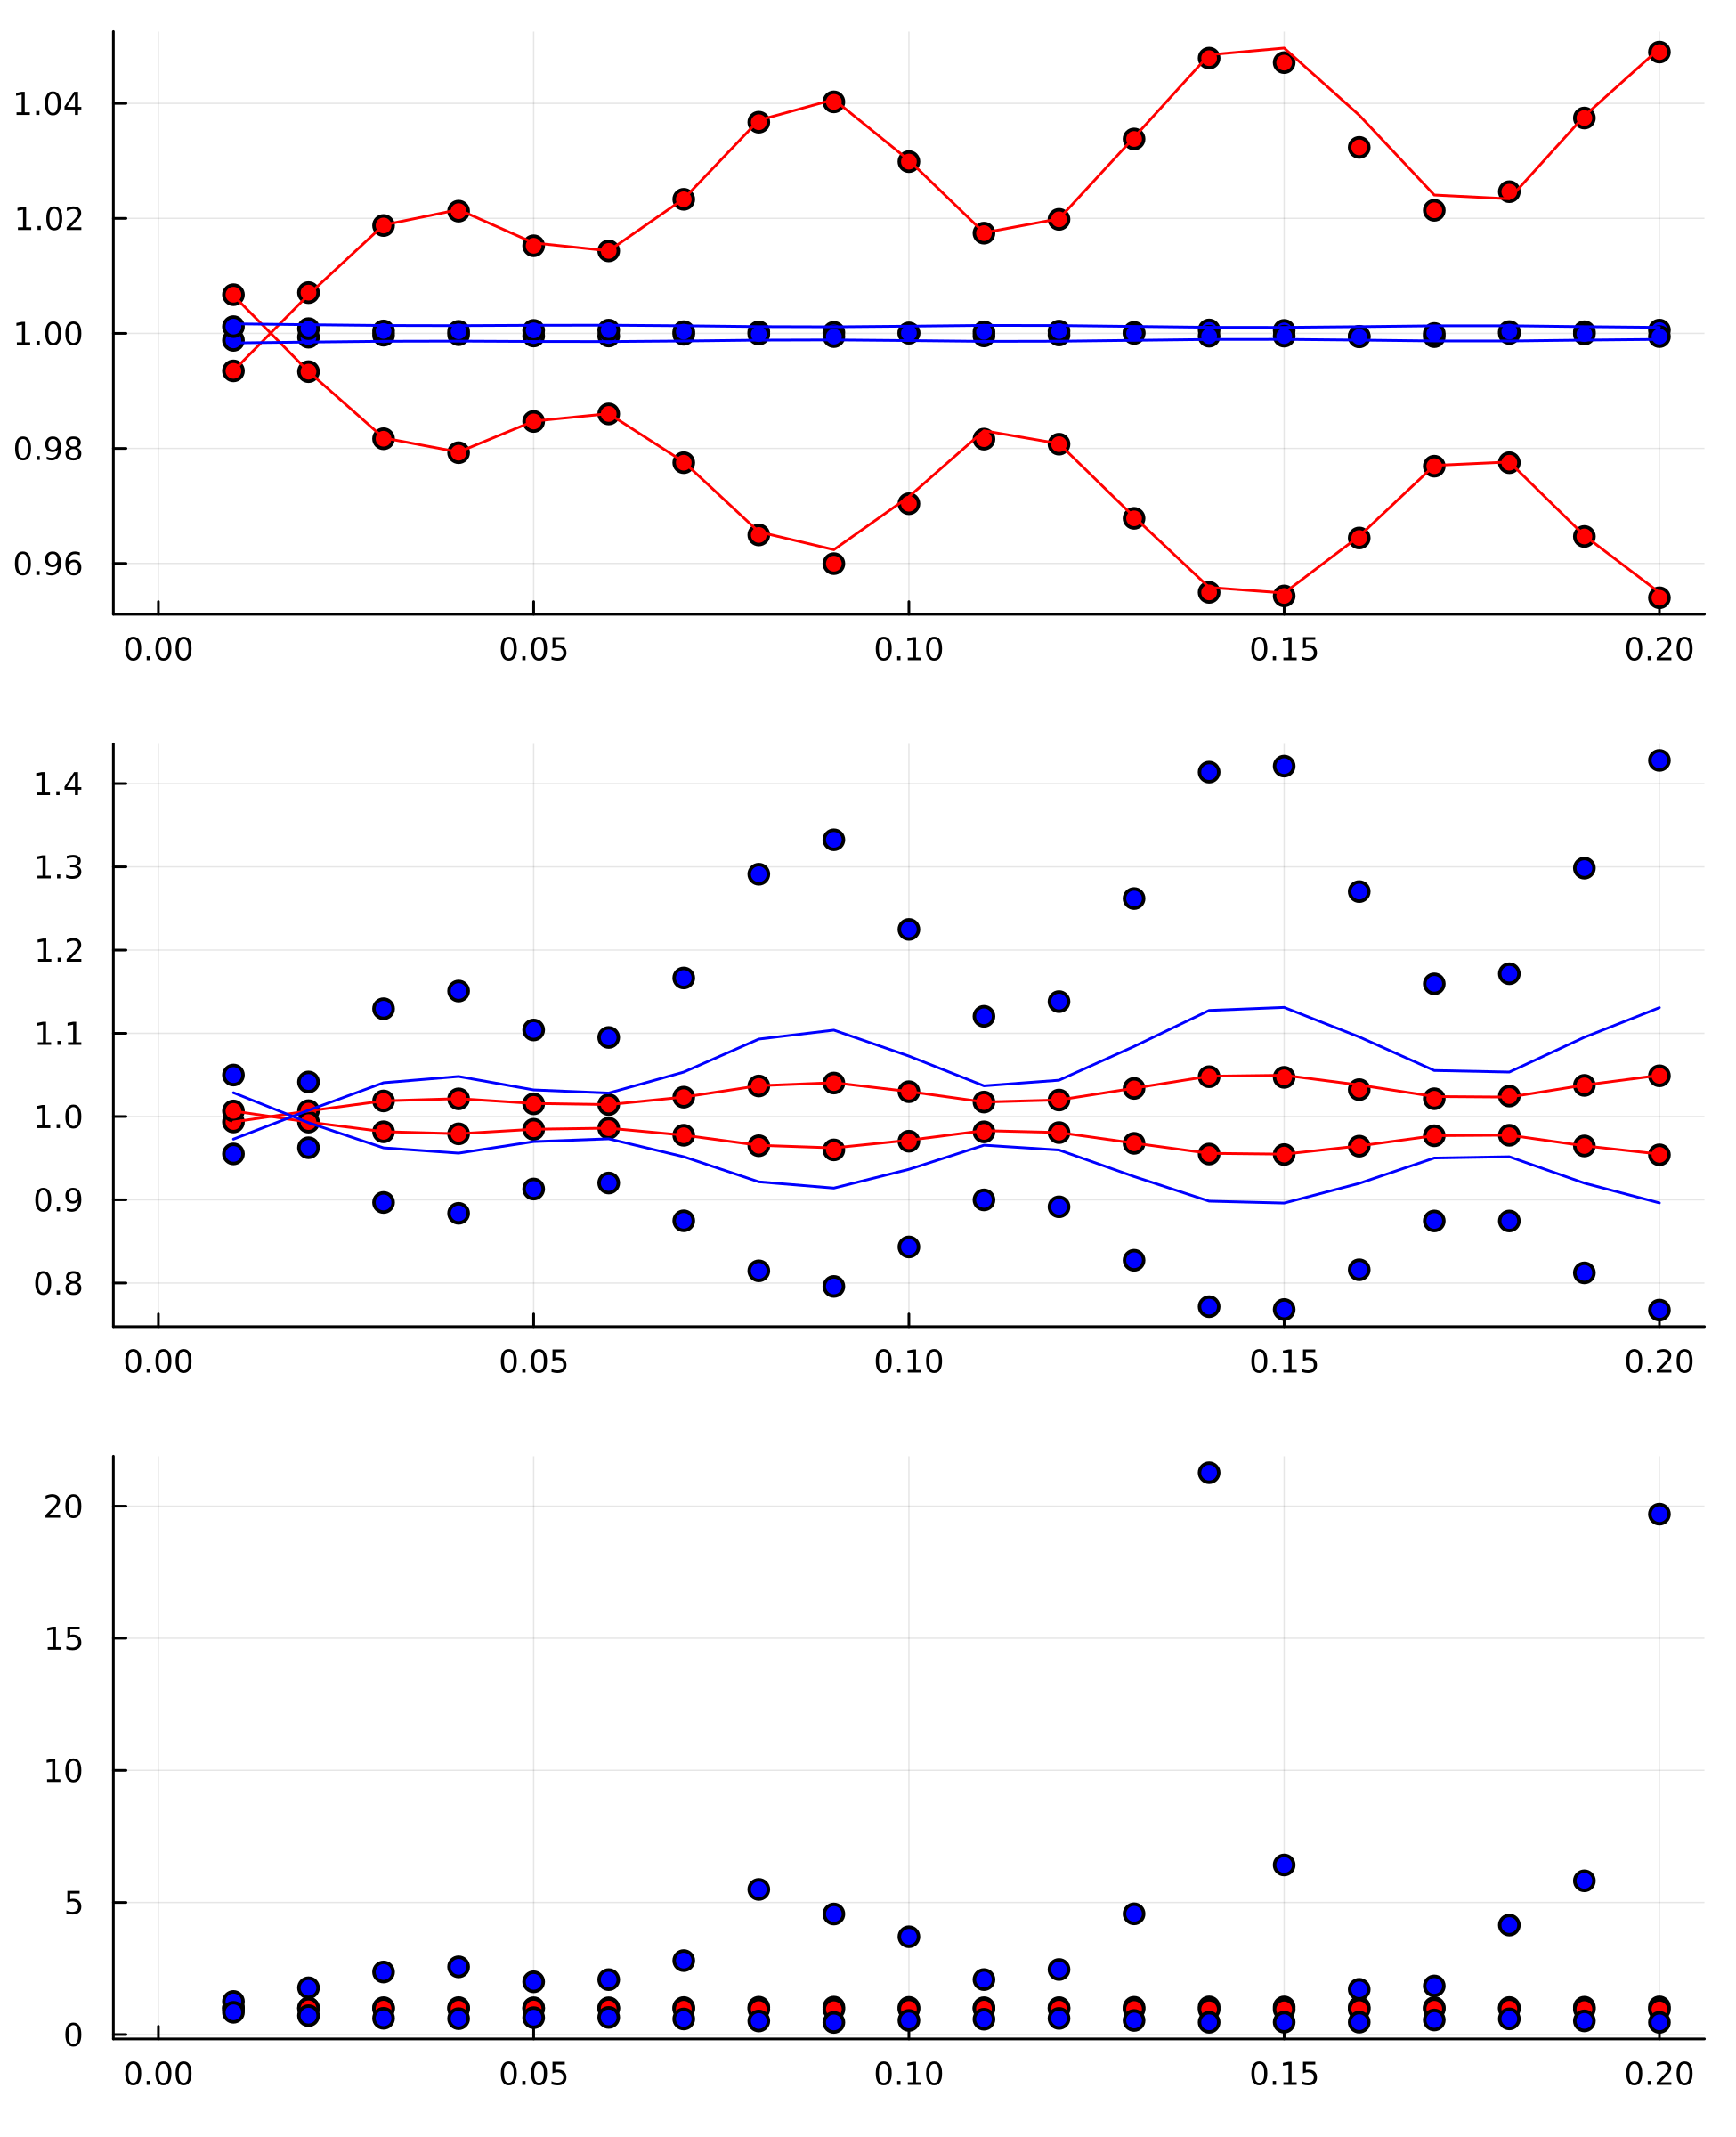

In [90]:
scatter(kgrid, B00fid./B00ap, label=:none, color=:red, layout=(3,1), size=(650, 800), dpi=300, subplot=1)
scatter!(kgrid, B00fid./B00am, label=:none, color=:red, subplot=1)
scatter!(kgrid, B00fid./B00ep, label=:none, color=:blue, subplot=1)
scatter!(kgrid, B00fid./B00em, label=:none, color=:blue, subplot=1)
αV = 1.01; ϵ=1.00
δαV = 1 - αV; δϵ = 1 - ϵ
B00th = B00fid .+ dB00k1*δαV + dB00k2*δαV + dB00k3*δαV + dB20k1*δϵ/sqrt(5) + dB20k2*δϵ/8/sqrt(5) + dB20k3*δϵ/8/sqrt(5) + B20fid*δϵ*3/sqrt(5)
plot!(kgrid, B00fid./B00th, label=:none, color=:red, subplot=1)
αV = 0.99; ϵ=1.00
δαV = 1 - αV; δϵ = 1 - ϵ
B00th = B00fid .+ dB00k1*δαV + dB00k2*δαV + dB00k3*δαV + dB20k1*δϵ/sqrt(5) + dB20k2*δϵ/8/sqrt(5) + dB20k3*δϵ/8/sqrt(5)  + B20fid*δϵ*3/sqrt(5)
plot!(kgrid, B00fid./B00th, label=:none, color=:red, subplot=1)
αV = 1.00; ϵ=1.01
δαV = 1 - αV; δϵ = 1 - ϵ
B00th = B00fid .+ dB00k1*δαV + dB00k2*δαV + dB00k3*δαV + dB20k1*δϵ/sqrt(5) + dB20k2*δϵ/8/sqrt(5) + dB20k3*δϵ/8/sqrt(5)  + B20fid*δϵ*3/sqrt(5)
plot!(kgrid, B00fid./B00th, label=:none, color=:blue, subplot=1)
αV = 1.00; ϵ=0.99
δαV = 1 - αV; δϵ = 1 - ϵ
B00th = B00fid .+ dB00k1*δαV + dB00k2*δαV + dB00k3*δαV + dB20k1*δϵ/sqrt(5) + dB20k2*δϵ/8/sqrt(5) + dB20k3*δϵ/8/sqrt(5)  + B20fid*δϵ*3/sqrt(5)
plot!(kgrid, B00fid./B00th, label=:none, color=:blue, subplot=1)
scatter!(kgrid, B20fid./B20ap, label=:none, color=:red, subplot=2)
scatter!(kgrid, B20fid./B20am, label=:none, color=:red, subplot=2)
scatter!(kgrid, B20fid./B20ep, label=:none, color=:blue, subplot=2)
scatter!(kgrid, B20fid./B20em, label=:none, color=:blue, subplot=2)
αV = 1.01; ϵ=1.00
δαV = 1 - αV; δϵ = 1 - ϵ
B20th = B20fid 
B20th += dB20k1*δαV + dB20k2*δαV + dB20k3*δαV
B20th += dB20k1*δϵ/sqrt(5) + dB20k2*δϵ/8/sqrt(5) + dB20k3*δϵ/8/sqrt(5) 
B20th += B20fid*δϵ*3/sqrt(5)
plot!(kgrid, B20fid./B20th, label=:none, color=:red, subplot=2)
αV = 0.99; ϵ=1.00
δαV = 1 - αV; δϵ = 1 - ϵ
B20th = B20fid 
B20th += dB20k1*δαV + dB20k2*δαV + dB20k3*δαV 
B20th += dB00k1*δϵ/sqrt(5) + dB00k2*δϵ/8/sqrt(5) + dB00k3*δϵ/8/sqrt(5) 
B20th += dB20k1*δϵ*2/7 + dB20k2*δϵ/28 + dB20k3*δϵ/28
plot!(kgrid, B20fid./B20th, label=:none, color=:red, subplot=2)
αV = 1.00; ϵ=1.01
δαV = 1 - αV; δϵ = 1 - ϵ
B20th = B20fid 
B20th += dB20k1*δαV + dB20k2*δαV + dB20k3*δαV 
B20th += dB00k1*δϵ/sqrt(5) + dB00k2*δϵ/8/sqrt(5) + dB00k3*δϵ/8/sqrt(5) 
B20th += dB20k1*δϵ*2/7 + dB20k2*δϵ/28 + dB20k3*δϵ/28
B20th += dB40k1*δϵ*6/7/sqrt(5) + dB40k2*δϵ*3/28/sqrt(5) + dB40k3*δϵ*3/28/sqrt(5)
B20th += B20fid*δϵ*3/7 + B40fid*δϵ*6/7/sqrt(5)
plot!(kgrid, B20fid./B20th, label=:none, color=:blue, subplot=2)
αV = 1.00; ϵ=0.99
δαV = 1 - αV; δϵ = 1 - ϵ
B20th = B20fid 
B20th += dB20k1*δαV + dB20k2*δαV + dB20k3*δαV 
B20th += dB00k1*δϵ/sqrt(5) + dB00k2*δϵ/8/sqrt(5) + dB00k3*δϵ/8/sqrt(5) 
B20th += dB20k1*δϵ*2/7 + dB20k2*δϵ/28 + dB20k3*δϵ/28
B20th += dB40k1*δϵ*6/7/sqrt(5) + dB40k2*δϵ*3/28/sqrt(5) + dB40k3*δϵ*3/28/sqrt(5)
B20th += B20fid*δϵ*3/7 + B40fid*δϵ*6/7/sqrt(5)
plot!(kgrid, B20fid./B20th, label=:none, color=:blue, subplot=2)
scatter!(kgrid, B40fid./B40ap, label=:none, color=:red, subplot=3)
scatter!(kgrid, B40fid./B40am, label=:none, color=:red, subplot=3)
scatter!(kgrid, B40fid./B40ep, label=:none, color=:blue, subplot=3)
scatter!(kgrid, B40fid./B40em, label=:none, color=:blue, subplot=3)

In [43]:
αV = 1.01, ϵ=1.00
δαV = 1 - αV, δϵ = 1 - ϵ
B00th = B00fid .+ dB00k1*(1.5*δαV +0.75*δϵ*0.33) + dB00k2*(1.5*(-0.36)*δαV + 0.75*δϵ*1.04) + dB00k3*((1.5)*(-0.65)*δαV + 0.75*δϵ*(-0.05))

21-element Vector{Float64}:
  0.0
  5.742283746337891e10
 -6.206338220214844e10
 -1.0259595162963867e11
 -6.454885726928711e10
 -3.1406634132385254e10
 -2.221270986175537e10
 -2.7197446907043457e10
 -2.866912755203247e10
 -1.9786313680648804e10
  ⋮
 -4.65624301815033e9
 -6.40266596698761e9
 -6.657737829208374e9
 -4.89864057636261e9
 -2.9075804328918457e9
 -1.5827303593158722e9
 -1.3628626580238342e9
 -1.8518323040008545e9
 -1.9289910316467285e9

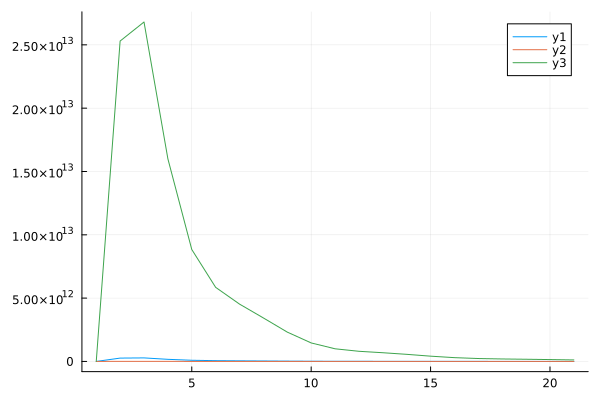

In [71]:
plot(B00fid)
plot!(B20fid)
plot!(B40fid)